This notebook is downloaded from **GitHub**

[Orignal Code](https://github.com/grimmdaniel/personality-trait-prediction)

To run this conect it with drive and pass the path where data set is saved  and run it one by one

In [1]:
# from sys import implementation
from google.colab import drive
drive.mount('/content/drive')

# !ls

%cd drive/My Drive/'FYP-Personality traits Assesment '/Implementation
!ls

ModuleNotFoundError: No module named 'google'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%config IPCompleter.greedy=True

In [ ]:
!pip install ffmpeg-python

In [ ]:
import librosa
from librosa import feature
import librosa.display
import numpy as np
import pandas as pd
import ffmpeg as ff
import os
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import random
import cv2
import pickle
import datetime

In [ ]:
# audio

def extract_audio_from_video(file_path: str) -> np.ndarray:
    inputfile = ff.input(file_path)
    out = inputfile.output('-', format='f32le', acodec='pcm_f32le', ac=1, ar='44100')
    raw = out.run(capture_stdout=True)
    del inputfile, out
    return np.frombuffer(raw[0],np.float32)

In [ ]:
# audio


def preprocess_audio_series(raw_data: np.ndarray) -> np.ndarray:
    N, M = 24, 1319
    mfcc_data = librosa.feature.mfcc(y=raw_data, n_mfcc=24)

    # Getting spectral mean (centroid)
    # mean = librosa.feature.spectral_centroid(result)

    # Standardizing MFCC (zero mean and unit variance)
    mfcc_data_standardized = (mfcc_data - np.mean(mfcc_data)) / np.std(mfcc_data)

    # Use pre-padding (Note: with 0, which is also the mean after standardization) to unify the length of the samples.
    number_of_columns_to_fill = M - mfcc_data_standardized.shape[1]
    padding = np.zeros((N, number_of_columns_to_fill))

    padded_data = np.hstack((padding, mfcc_data_standardized))

    # Reshaping to N,M,1
    return padded_data.reshape(N, M, 1)


In [ ]:
def get_number_of_frames(file_path: str) -> int:
    probe = ff.probe(filePath)
    video_streams = [stream for stream in probe["streams"] if stream["codec_type"] == "video"]
    #width = video_streams[0]['coded_width']
    #height = video_streams[0]['coded_height']
    del probe
    return video_streams[0]['nb_frames']

In [ ]:
def extract_N_video_frames(file_path: str, number_of_samples: int = 6) -> List[np.ndarray]:
    nb_frames = int(get_number_of_frames(file_path= filePath))

    video_frames = []
    random_indexes = random.sample(range(0, nb_frames), number_of_samples)

    cap = cv2.VideoCapture(filePath)
    for ind in random_indexes:
        cap.set(1,ind)
        res, frame = cap.read()
        video_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
    del cap, random_indexes
    return video_frames

In [ ]:
def resize_image(image: np.ndarray, new_size: Tuple[int,int]) -> np.ndarray:
    return cv2.resize(image, new_size, interpolation = cv2.INTER_AREA)

In [ ]:
def crop_image_window(image: np.ndarray, training: bool = True) -> np.ndarray:
    height, width, _ = image.shape
    if training:
        MAX_N = height - 128
        MAX_M = width - 128
        rand_N_index, rand_M_index = random.randint(0, MAX_N) , random.randint(0, MAX_M)
        return image[rand_N_index:(rand_N_index+128),rand_M_index:(rand_M_index+128),:]
    else:
        N_index = (height - 128) // 2
        M_index = (width - 128) // 2
        return image[N_index:(N_index+128),M_index:(M_index+128),:]

In [ ]:
def reading_label_data(file_name: str, dictionary: Dict[str,str]) -> np.ndarray:
    features = ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']
    extracted_data = [float(dictionary[label][file_name]) for label in features]
    return np.stack(extracted_data).reshape(5,1)

In [ ]:
def preprocessing_input(file_path: str, file_name: str, dictionary: Dict[str,str], training: bool = True) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    #Audio
    extracted_audio_raw = extract_audio_from_video(file_path= filePath)
    preprocessed_audio = preprocess_audio_series(raw_data= extracted_audio_raw)

    #Video
    sampled = extract_N_video_frames(file_path= filePath, number_of_samples= 6)
    resized_images = [resize_image(image= im, new_size= (248,140)) for im in sampled]
    cropped_images = [crop_image_window(image= resi,training= training) / 255.0 for resi in resized_images]
    preprocessed_video = np.stack(cropped_images)

    #Ground Truth
    video_gt = reading_label_data(file_name= file_name, dictionary= dictionary)
    del  sampled, resized_images, cropped_images
    return (preprocessed_audio, preprocessed_video, video_gt)

### Getting train set

In [ ]:
# !ls
# %cd 'FYP-Personality traits Assesment '/Implementation
!ls

 Big5	    'PTA with audio.ipynb'   test_set.dat       training_set.dat     validation_set.dat
 PTA.ipynb   test_set.csv	     training_set.csv   validation_set.csv


In [ ]:
training_set_data = []
path = 'Big5/train'
gt = pickle.load( open( "Big5/gt/annotation_training.pkl", "rb" ), encoding='latin1' )
t1 = datetime.datetime.utcnow()
for filename in os.listdir(path):
    filePath = path+'/'+filename
    training_set_data.append(preprocessing_input(file_path= filePath, file_name= filename, dictionary= gt, training= True))
t2 = datetime.datetime.utcnow()
#Measuring execution time
print('Elapsed time: ' + str(t2-t1))

Elapsed time: 0:03:57.844324


In [ ]:
savename = 'training_set.dat'
with open(savename, "wb") as f:
    pickle.dump(training_set_data, f)

### Getting validation set

In [ ]:
validation_set_data = []
path = 'Big5/valid'
gt = pickle.load( open( "Big5/gt/annotation_validation.pkl", "rb" ), encoding='latin1' )
t1 = datetime.datetime.utcnow()
for filename in os.listdir(path):
    filePath = path+'/'+filename
    validation_set_data.append(preprocessing_input(file_path= filePath, file_name= filename, dictionary= gt, training= False))
t2 = datetime.datetime.utcnow()
#Measuring execution time
print('Elapsed time: ' + str(t2-t1))

Elapsed time: 0:01:26.576944


In [ ]:
savename = 'validation_set.dat'
with open(savename, "wb") as f:
    pickle.dump(validation_set_data, f)

### Getting test set

In [ ]:
test_set_data = []
path = 'Big5/test'
gt = pickle.load( open( "Big5/gt/annotation_test.pkl", "rb" ), encoding='latin1' )
t1 = datetime.datetime.utcnow()
for filename in os.listdir(path):
    filePath = path+'/'+filename
    test_set_data.append(preprocessing_input(file_path= filePath, file_name= filename, dictionary= gt, training= False))
t2 = datetime.datetime.utcnow()
#Measuring execution time
print('Elapsed time: ' + str(t2-t1))

Elapsed time: 0:01:12.484174


In [ ]:
savename = 'test_set.dat'
with open(savename, "wb") as f:
    pickle.dump(test_set_data, f)

### Restarting kernel to free up memory, and then load data

In [ ]:
with open('training_set.dat', "rb") as training_file:
    train_set_data = pickle.load(training_file)

In [ ]:
with open('validation_set.dat', "rb") as validation_file:
    validation_set_data = pickle.load(validation_file)

In [ ]:
with open('test_set.dat', "rb") as test_file:
    test_set_data = pickle.load(test_file)

<Axes: ylabel='Density'>

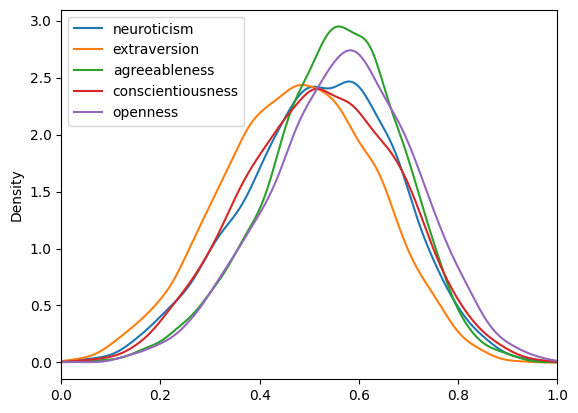

In [ ]:
gt = pickle.load( open( "Big5/gt/annotation_training.pkl", "rb" ), encoding='latin1' )
neuroticism = list(gt['neuroticism'].values())
extraversion = list(gt['extraversion'].values())
agreeableness = list(gt['agreeableness'].values())
conscientiousness = list(gt['conscientiousness'].values())
openness = list(gt['openness'].values())

df = pd.DataFrame({'neuroticism': neuroticism,'extraversion': extraversion,'agreeableness':agreeableness,'conscientiousness':conscientiousness,'openness':openness})
df.plot(kind='density',xlim=(0,1))

### Plotting number of samples in each set

In [ ]:
print(len(train_set_data))
print(len(validation_set_data))
print(len(test_set_data))

60
20
20


In [ ]:
train_random_index = random.randint(0, len(train_set_data)-1)
validation_random_index = random.randint(0, len(validation_set_data)-1)
test_random_index = random.randint(0, len(test_set_data)-1)

In [ ]:
shape = train_set_data[train_random_index][0].shape
mfcc_train = train_set_data[train_random_index][0].reshape(shape[0],shape[1])

shape = validation_set_data[validation_random_index][0].shape
mfcc_validation = validation_set_data[validation_random_index][0].reshape(shape[0],shape[1])

shape = test_set_data[test_random_index][0].shape
mfcc_train = test_set_data[test_random_index][0].reshape(shape[0],shape[1])

mfccs = [mfcc_train,mfcc_validation,mfcc_train]

### Displaying 3 video samples from train,validation and test sets

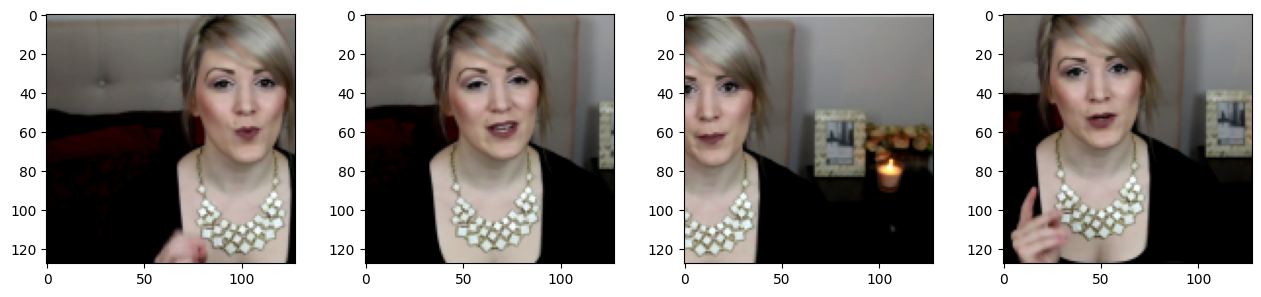

In [ ]:
images_to_plot = []
images_to_plot.extend([(train_set_data[train_random_index][1])[i,:,:,:] for i in range(0,6)])
images_to_plot.extend([(validation_set_data[validation_random_index][1])[i,:,:,:] for i in range(0,6)])
images_to_plot.extend([(test_set_data[test_random_index][1])[i,:,:,:] for i in range(0,6)])


plt.figure(figsize=(24,11))

for i in range(4):
    plt.subplot(3,6,i+1)
    plt.imshow(images_to_plot[i])
plt.show()

### Displaying audio MFCC

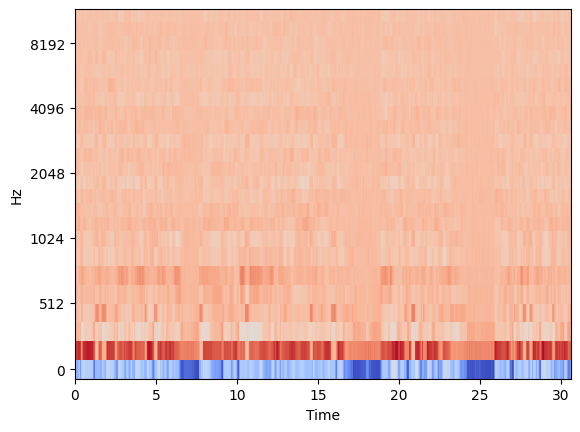

In [ ]:
librosa.display.specshow(mfccs[0], x_axis='time', y_axis='mel')

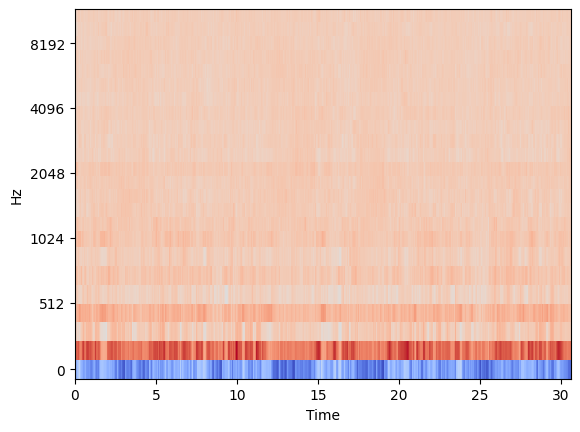

In [ ]:
librosa.display.specshow(mfccs[1], x_axis='time', y_axis='mel')

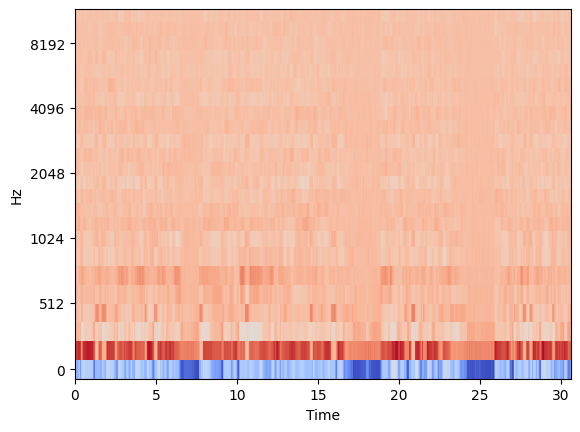

In [ ]:
librosa.display.specshow(mfccs[2], x_axis='time', y_axis='mel')

### Printing personality traits

In [ ]:
personality_train = train_set_data[train_random_index][2]
personality_validation = validation_set_data[validation_random_index][2]
personality_test = test_set_data[test_random_index][2]
personalities = ['Neuroticism','Extraversion','Agreeableness','Conscientiousness','Openness']

#### Train

In [ ]:
for label, value in zip(personalities,personality_train):
    print(label + ': ' + str(value[0]))

Neuroticism: 0.6355140186915887
Extraversion: 0.6875
Agreeableness: 0.6153846153846153
Conscientiousness: 0.8834951456310681
Openness: 0.6777777777777777


#### Validation

In [ ]:
for label, value in zip(personalities,personality_validation):
    print(label + ': ' + str(value[0]))

Neuroticism: 0.48598130841121495
Extraversion: 0.5833333333333333
Agreeableness: 0.3736263736263736
Conscientiousness: 0.5339805825242718
Openness: 0.5444444444444444


#### Test

In [ ]:
for label, value in zip(personalities,personality_test):
    print(label + ': ' + str(value[0]))

Neuroticism: 0.28037383177570097
Extraversion: 0.1458333333333333
Agreeableness: 0.4175824175824176
Conscientiousness: 0.31067961165048547
Openness: 0.41111111111111115


### Converting sets to model format

In [ ]:
def reshape_to_expected_input(dataset: List[Tuple[np.ndarray,np.ndarray,np.ndarray]]) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:

    x0_list = []
    x1_list = []
    y_list = []
    for i in range(0,len(dataset)):
        x0_list.append(dataset[i][0])
        x1_list.append(dataset[i][1])
        y_list.append(dataset[i][2])
    return (np.stack(x0_list),np.stack(x1_list),np.stack(y_list))

In [ ]:
train_input = reshape_to_expected_input(dataset= train_set_data)
del train_set_data
validation_input = reshape_to_expected_input(dataset= validation_set_data)
del validation_set_data
test_input = reshape_to_expected_input(dataset= test_set_data)
del test_set_data

## Creating Model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, LSTM, Bidirectional, Lambda, Dropout, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import TimeDistributed

### Audio subnetwork

In [ ]:
audio_input = Input(shape=(24,1319,1))
audio_model = Conv2D(32, kernel_size=(3,3),activation='relu')(audio_input)
audio_model = BatchNormalization()(audio_model)
audio_model = MaxPooling2D(pool_size=(2, 2))(audio_model)
audio_model = Conv2D(32, kernel_size=(3,3),activation='relu')(audio_model)
audio_model = BatchNormalization()(audio_model)
audio_model = MaxPooling2D(pool_size=(2, 2))(audio_model)
audio_model = Flatten()(audio_model)
audio_model = Dense(128, activation='relu')(audio_model)
audio_subnetwork = Model(inputs=audio_input,outputs=audio_model)

### Visual subnetwork

In [ ]:
from keras.applications import vgg16

In [ ]:
visual_model = Input(shape=(6,128,128,3))

cnn = vgg16.VGG16(weights="imagenet", include_top=False, pooling='max')
cnn.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
encoded_frame = TimeDistributed(Lambda(lambda x: cnn(x)))(visual_model)
encoded_vid = LSTM(64)(encoded_frame)

visual_subnetwork = Model(inputs=visual_model,outputs=encoded_vid)

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
  <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
  <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
  <tf.Variable 'block2_conv2/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32>
  <tf.Variable 'block3_conv1/bias:0' shape=(256,) dtype=float32>
  <tf.Variable 'block3_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32>
  <tf.Variable 'block3_conv2/bias:0' shape=(256,) dtype=float32>
  <tf.Variable 'block3_conv3/kernel:0' shape=(

In [ ]:
combined = Concatenate()([audio_subnetwork.output, visual_subnetwork.output])
final1 = Dense(256, activation='softmax')(combined)
final2 = Dense(5, activation='relu')(final1)

In [ ]:
combined_network = Model(inputs=[audio_input, visual_model], outputs=final2)
combined_network.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 1319, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 22, 1317, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 22, 1317, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 11, 658, 32)          0         ['batch_normalization[0]

In [ ]:
combined_network.compile(optimizer = 'adam',loss = 'mean_absolute_error',metrics=['mae'])

### Training

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=10)

In [ ]:
history = combined_network.fit(x = [train_input[0],train_input[1]],
                               y = train_input[2],
                               validation_data = ([validation_input[0],validation_input[1]],validation_input[2]),
                               epochs = 30,
                               verbose = 1,
                               callbacks = [early_stopping])


NameError: name 'train_input' is not defined

In [ ]:
# # prompt: what is happening in above cell

# The code snippet you provided is a Python script that preprocesses and loads a dataset for training a personality trait prediction model. The script performs the following steps:

# 1. **Imports necessary libraries**:
#    - `sys`: Used to access the Python interpreter's implementation.
#    - `librosa`: Used for audio processing and feature extraction.
#    - `numpy`: Used for numerical computations.
#    - `pandas`: Used for data manipulation and analysis.
#    - `ffmpeg`: Used for extracting audio from video files.
#    - `os`: Used for interacting with the operating system.
#    - `random`: Used for generating random numbers.
#    - `cv2`: Used for image processing.
#    - `pickle`: Used for saving and loading data.
#    - `datetime`: Used for measuring execution time.
#    - `tensorflow.keras.models`: Used for creating and training neural network models.
#    - `tensorflow.keras.layers`: Used for defining different types of neural network layers.
#    - `keras.applications`: Used for accessing pre-trained models.
#    - `keras.callbacks`: Used for defining callbacks for the training process.

# 2. **Defines functions**:
#    - `extract_audio_from_video(file_path)`: This function extracts the audio track from a video file using `ffmpeg`.
#    - `preprocess_audio_series(raw_data)`: This function preprocesses the extracted audio data by calculating Mel-frequency cepstral coefficients (MFCCs) and standardizing them.
#    - `get_number_of_frames(file_path)`: This function uses `ffmpeg` to determine the number of frames in a video file.
#    - `extract_N_video_frames(file_path, number_of_samples)`: This function randomly selects a specified number of frames from a video file.
#    - `resize_image(image, new_size)`: This function resizes an image to a given size.
#    - `crop_image_window(image, training)`: This function crops a window from an image, either randomly (during training) or using a fixed center point (during testing).
#    - `reading_label_data(file_name, dictionary)`: This function reads the personality trait labels for a specific video file from a dictionary.
#    - `preprocessing_input(file_path, file_name, dictionary, training)`: This function preprocesses a single video file by extracting and preparing the audio and video data, and reading the corresponding personality trait labels.
#    - `reshape_to_expected_input(dataset)`: This function converts a list of preprocessed data samples into the expected input format for the neural network model.

# 3. **Loads the training, validation, and test datasets**:
#    - The script loads the datasets from pickle files, which were previously created by running the preprocessing functions on the original video files and saving the results.

# 4. **Prints statistics and visualizations**:
#    - The script prints the number of samples in each dataset.
#    - The script displays random samples of video frames and MFCCs from each dataset.
#    - The script prints the personality trait labels for a random sample from each dataset.

# 5. **Converts the datasets to the model input format**:
#    - The script uses the `reshape_to_expected_input` function to convert the training, validation, and test datasets into the expected input format for the neural network model.

# 6. **Creates the combined neural network model**:
#    - The script defines two subnetworks: one for processing audio data and one for processing video data.
#    - The audio subnetwork consists of convolutional layers, batch normalization, max pooling, and a dense layer.
#    - The video subnetwork uses a pre-trained VGG16 model to extract features from each video frame, followed by an LSTM layer.
#    - The outputs of the audio and video subnetworks are concatenated and fed into a final dense layer that predicts the personality trait scores.

# 7. **Compiles the model**:
#    - The script compiles the combined model with the Adam optimizer and the mean absolute error loss function.
#    - The script also defines an early stopping callback to stop training if the validation loss does not improve for 10 epochs.

# 8. **Trains the model**:
#    - The script trains the combined model on the training dataset, using the validation dataset for monitoring the training progress.

# 9. **Saves the model**:
#    - The script saves the trained model to a file called `best_model.h5`.

NameError: name 'history' is not defined

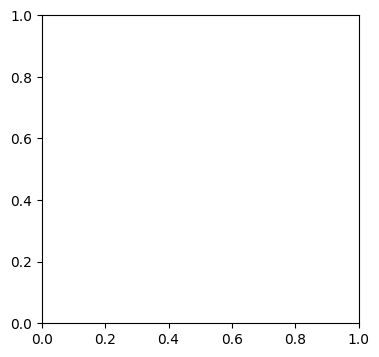

In [ ]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train MAE', 'Validation MAE'], loc='upper right')

#### Evaluate model on train set

In [ ]:
loss, mae = combined_network.evaluate([test_input[0],test_input[1]],test_input[2], verbose=0)

print('Test loss: {}'.format(loss))

### 1-MAE

In [ ]:
print('1-MAE: ' + str(1-mae))

In [ ]:
one_minus_mae_train = [1-maee for maee in history.history['mae']]
one_minus_mae_val = [1-maee for maee in history.history['val_mae']]

In [ ]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(one_minus_mae_train)
plt.plot(one_minus_mae_val)
plt.title('Model 1-MAE')
plt.ylabel('1-MAE')
plt.xlabel('Epoch')
plt.legend(['Train 1-MAE', 'Validation 1-MAE'], loc='lower right')

### Coefficient of determination (R^2)

In [ ]:
y_pred = combined_network.predict([test_input[0],test_input[1]])
pred_shape = y_pred.shape
y_pred = y_pred.reshape(pred_shape[0],pred_shape[1],1)

In [ ]:
normalized = y_pred / np.max(y_pred)

In [ ]:
plt.scatter(test_input[2][:,0,:], normalized[:,0,:], marker='o');
print(test_input[2])
plt.ylabel('Y_Neuroticism')
plt.xlabel('Y_pred_Neuroticism')

In [ ]:
# prompt: print the above cell in diffrent way for opennes

y_pred = combined_network.predict([test_input[0],test_input[1]])
pred_shape = y_pred.shape
y_pred = y_pred.reshape(pred_shape[0],pred_shape[1],1)
normalized = y_pred / np.max(y_pred)
plt.scatter(test_input[2][:,4,:], normalized[:,4,:], marker='o');
print(test_input[2][:,4,:])
plt.ylabel('Y_Openness')
plt.xlabel('Y_pred_Openness')


#### Coefficient Determination (R^2)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
pers = ['Neuroticism','Extraversion','Agreeableness','Conscientiousness','Openness']
r2s = [r2_score(test_input[2][:,i,:], normalized[:,i,:]) for i in range(5)]
for pers, r2 in zip(pers,r2s):
    print(pers + ': ' + str(r2))

In [ ]:
# !pip install --upgrade librosa


In [ ]:
# prompt: create 6 graph 5 for each trait and one will be combined and display the pictures extrated from my provided video

import matplotlib.pyplot as plt
import cv2

video_path = 'Big5/testVideo/testing 1.mp4'

cap = cv2.VideoCapture(video_path)

# Extract 6 frames from the video
frames = []
for i in range(len(extract_N_video_frames(file_path= video_path))):
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
    else:
        break

# Close the video capture object
cap.release()


audio_data, sample_rate = librosa.load(video_path)
preprocessed_audio = preprocess_audio_series(raw_data= audio_data.reshape(-1))
print(video_path)
# frams = extract_N_video_frames(file_path= video_path)
resized_images = [resize_image(image= im, new_size= (128,1280)) for im in frames]
cropped_images = [crop_image_window(image= resi,training= True) / 255.0 for resi in resized_images]
preprocessed_video = np.stack(cropped_images)


# input=preprocessing_input(file_path= 'Big5/testVideo/', file_name= 'testing.mp4', dictionary= 'testVideo', training= True)
# ### Predict personality traits
# predicted_personality_traits = combined_network.predict(input)


# ### Predict personality traits
predicted_personality_traits = combined_network.predict([preprocessed_audio.reshape(1,24,1319,1),preprocessed_video.reshape(1,6,128,128,3)])

# ### Print predicted personality traits
personalities = ['Neuroticism','Extraversion','Agreeableness','Conscientiousness','Openness']
for label, value in zip(personalities,predicted_personality_traits[0]):
    print(label + ': ' + str(value))

# Load the video



# Create a figure with 6 subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# Plot each frame on a separate subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(frames[i])
    ax.axis('off')

# Add a title to the figure
fig.suptitle('Extracted Frames from Video')

# Show the figure
plt.show()



In [ ]:

personalities = ['Neuroticism', 'Extraversion', 'Agreeableness', 'Conscientiousness', 'Openness']

# Plotting the predicted values
plt.figure(figsize=(10, 6))
plt.barh(personalities, predicted_personality_traits[0], color='#28282b')
plt.xlabel('Predicted Values')
plt.title('Predicted Personality Traits')
plt.xlim(0, 1)  # Setting the x-axis limit from 0 to 1
# plt.gca().invert_yaxis()  # Inverting the y-axis to display labels from top to bottom
plt.show()

In [ ]:
# Define functions for audio and video preprocessing
def extract_audio(video_path):
    audio, _ = librosa.load(video_path, sr=44100, mono=True)
    return audio

def extract_frames(video_path, num_frames=6):
    cap = cv2.VideoCapture(video_path)
    frames = []
    for _ in range(num_frames):
        ret, frame = cap.read()
        if ret:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        else:
            break
    cap.release()
    return frames

# Define function to predict personality traits and display results
def predict_personality_traits(video_path):
    audio = extract_audio(video_path)
    frames = extract_frames(video_path)

    # Preprocess audio and video data
    audio_input = np.expand_dims(audio, axis=0)  # Add batch dimension
    audio_input = audio_input.reshape(1, -1, 1)  # Reshape to match expected shape

    frames_input = np.expand_dims(frames, axis=0)  # Add batch dimension

    print(frames_input.shape)
    frames_input = np.transpose(frames_input, (0, 2, 3, 1))  # Change dimension order to (batch, height, width, channels)

    # Predict personality traits
    predictions = combined_network.predict([audio_input, frames_input])

    # Display the predicted personality traits (OCEAN values)
    personalities = ['Neuroticism', 'Extraversion', 'Agreeableness', 'Conscientiousness', 'Openness']
    for trait, value in zip(personalities, predictions[0]):
        print(f'{trait}: {value}')

    # Display the frames on which processing is done
    plt.figure(figsize=(12, 6))
    for i, frame in enumerate(frames):
        plt.subplot(2, 3, i + 1)
        plt.imshow(frame)
        plt.axis('off')
        plt.title(f'Frame {i+1}')
    plt.show()

# Specify the folder containing the video files
video_folder = 'Big5/test'

# Iterate over the video files in the folder
for filename in os.listdir(video_folder):
    if filename.endswith('.mp4'):
        video_path = os.path.join(video_folder, filename)
        print(f'Processing video: {filename}')
        predict_personality_traits(video_path)